# Coördinated Spiking Model ($\textit{d}$-dimensional input signal)

The following code simulates a Coördinated Spiking Model with $\textit{N}$ neurons and a $\textit{d}$-dimensional input. The model contains the following functions:

- initialize_weights: initialize weights for the different neurons
- initialize_params_N: initialize the variables and parameters for simulating the network
- TVS_N: creates sinusoidal input signal with $\textit{d}$ dimensions
- run_N: runs the spiking network model
- plot_N: plots the results (input + input estimate, spike trains and voltages)

In addition, other functions have been added to plot the parameters of the network:
- plot_weights: plot the weights for a 2- and 3- dimensional input signal.
- plot_boundary: plot the error space with the error boundaries for the different neurons

Install required packages

In [111]:
import numpy as np
import pylab as pl
import math
from matplotlib import colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import random
import os

# enable HoloView
import pandas as pd
import holoviews as hv
from holoviews import opts

# enable animation
import matplotlib.animation as animation

Function used for plotting the spike trains

In [2]:
def zero_to_nan(values):
    """Replace every 0 with 'nan' and return a copy."""
    
    return [float('nan') if x==0 else x for x in values]

## $\textit{N}$-neurons

Initialize weights

In [72]:
def initialize_weights(N, d):
    """ Initialize decoding weights of the different neurons. """
    
    if d == 1:
        # 1-dimensional input signal
        
        weights = np.linspace(0, 2 * np.pi, N + 1)
        D = []
        
        for i in range(N):
            D.append(np.cos(weights[i]))
        
        D = np.asarray(D).reshape((N, d))
        
    elif d == 2:
        # 2-dimensional input signal
        
        weights = np.linspace(0, 2 * np.pi, N + 1)
        
        D = []

        for i in range(N):
                D_temp = [np.sin(weights[i]), np.cos(weights[i])]
                D.append(D_temp)

        D = np.asarray(D).reshape((N, d))
        
    else:
        D = np.random.normal(0, 0.4, size=(N, d)) 
        
    return D

Initialize parameters

In [4]:
def initialize_params_N(N, d, iterations, dt, D):
    """ Initialize variables and parameters. """
    
    # timesteps
    t = np.arange(0, iterations) * dt

    # voltage
    voltage = np.zeros((N, iterations))

    # input estimate
    if d > 1:
        x_est = np.zeros((d, iterations))
    else:
        x_est = np.zeros(iterations)

    # spike train
    o = np.zeros((N, iterations))

    # threshold
    T = []
    
    for i in range(N):
        T.append((np.dot(D[i,:], D[i,:]))/2)
    
    return (t, voltage, x_est, o, T)

In [80]:
def TVS_N(iterations):
    "Create time varying signal following a sinusoidal function. "
    
    c = []
    x = []
    
    # number of sinus periods (total # of sinus periods = 2 * cycles)
    cycles = 2
    t = np.linspace(0, np.pi, d + 1)       # starting points of d-dimensioan sinusoidal input signals
    
    for i in range(d):
        
        x_temp = np.sin(2 * np.linspace(-cycles * np.pi, cycles * np.pi, iterations) + t[i])
        dxdt = np.diff(x_temp)/dt
        c_temp = x_temp[:-1] + dxdt

        c.extend(c_temp)
        x.extend(x_temp)
    
    if d > 1:
        c = np.asarray(c).reshape((d, iterations - 1))
        x = np.asarray(x).reshape((d, iterations))

    return(c, x)

In [70]:
def run_N(tau, beta):
    """ Run simulation with time constant, tau, and constant for the cost, beta. """
    
    for t in range(1, iterations):
        
        if d > 1:
        # input signal with dimensions > 1
            
            # update input estimate
            reset = np.zeros((1, d))
            for i in range(N):
                if o[i, t - 1] > 0:
                    reset = np.dot(D[i, :], o[i, t - 1])
            
            dxestdt = (-1/tau) * x_est[:, t - 1] + reset
            x_est[:, t] = x_est[:, t - 1] + dt * dxestdt
            
            # update voltage
            reset = np.zeros((1, N))
            for i in range(N):
                 if o[i, t - 1] > 0:
                        reset = np.dot(D, D[i, :]) * o[i, t - 1]
            dVdt = (-1/tau) * voltage[:, t - 1] + np.dot(D, c[:,t - 1]) - reset
            voltage[:, t] = voltage[:, t - 1] + dt * dVdt
         
        else:
        # input signal with 1 dimension

            # update input estimate
            reset = np.dot(D.T, o[:, t - 1])
            dxestdt = (-1/tau) * x_est[t - 1] + reset
            x_est[t] = x_est[t - 1] + dt * dxestdt

            # update voltage
            reset = np.dot(D.T ** 2, o[:, t - 1])
            dVdt = (-1/tau) * voltage[:, t - 1] + np.dot(D, c[t - 1]).T - reset
            voltage[:, t] = voltage[:, t - 1] + dt * dVdt

        # check for neurons with voltages above threshold
        above_threshold = []

        for i in range(N): 
            if voltage[i, t] > T[i]:
                above_threshold.append(i)

        # reset neurons' voltages when threshold is exceeded
        if len(above_threshold) > 0:

            # select spiking neuron
            spike_neuron = np.random.choice(above_threshold)
            
            # update spikes
            o[spike_neuron, t] = 1/dt

In [84]:
def plot_N(color):
    """ Plots the results, including input and input estimate per dimension 
        as well as the spike trains and voltages of the individual neurons. """
    
    plot = d + N + 1
    pl.subplots(plot, 1, figsize=(12, 13))
    pl.subplots_adjust(hspace=0.4)
    counter = 1
    
    # enable LaTeX
    pl.rc('text', usetex=True)
    
    # plot input and input estimate per dimension over time
    if d > 1:
        # input signal with dimensions > 1
        
        for i in range(1, d + 1):
            # input signal with more than 1 dimension
            pl.subplot(plot, 1, counter)
            pl.plot(x_est[i - 1,:], label=r'$\hat{x}_{%i}$' %i, color='gray')
            pl.plot(x[i - 1,:], label='$x_{%i}$' %i, color='k')
            pl.yticks([])
            pl.xticks([])
            pl.legend(loc='center left', bbox_to_anchor=(1, 0.5),  fontsize=15)

            counter = counter + 1
    else:
        # input signal with 1 dimension

        pl.subplot(plot, 1, counter)
        pl.plot(x_est, label=r'$\hat{x}$', color='gray')
        pl.plot(x, label='$x$', color='k')
        pl.yticks([])
        pl.xticks([])
        pl.legend(loc='center left', bbox_to_anchor=(1, 0.5),  fontsize=15)

        counter = counter + 1
    
    # plot spike trains per neuron over time
    pl.subplot(plot, 1, counter)
    
    for i in range(1, N + 1):
        values = zero_to_nan(o[i - 1, :] * i)
        pl.scatter(np.arange(0, iterations), values, color=color[i - 1][:]/255, label='N%i' %i, s=1.5)
    
    pl.title('Spike train', fontsize=15)
    pl.yticks([])
    pl.xticks([])
    pl.ylim(0, 10 * N + 10)
    pl.xlim(0, iterations)
    pl.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15, markerscale=5)
    
    counter = counter + 1
    
    # plot voltage per neuron over time
    for i in range(1, N + 1):
        pl.subplot(plot, 1, counter)
        pl.plot(voltage[i - 1], color=color[i - 1][:]/255, label='voltage')
        pl.plot(np.arange(0, iterations), np.ones(iterations) * T[i - 1], color='gray', label='threshold')
        pl.xlim(0, iterations)
        pl.ylabel('Voltage')
        pl.title('Neuron %i' %i,  fontsize=15)
        pl.yticks([])
        pl.xticks([])

        counter = counter + 1
        
        pl.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15)
        
    pl.xlabel('time')

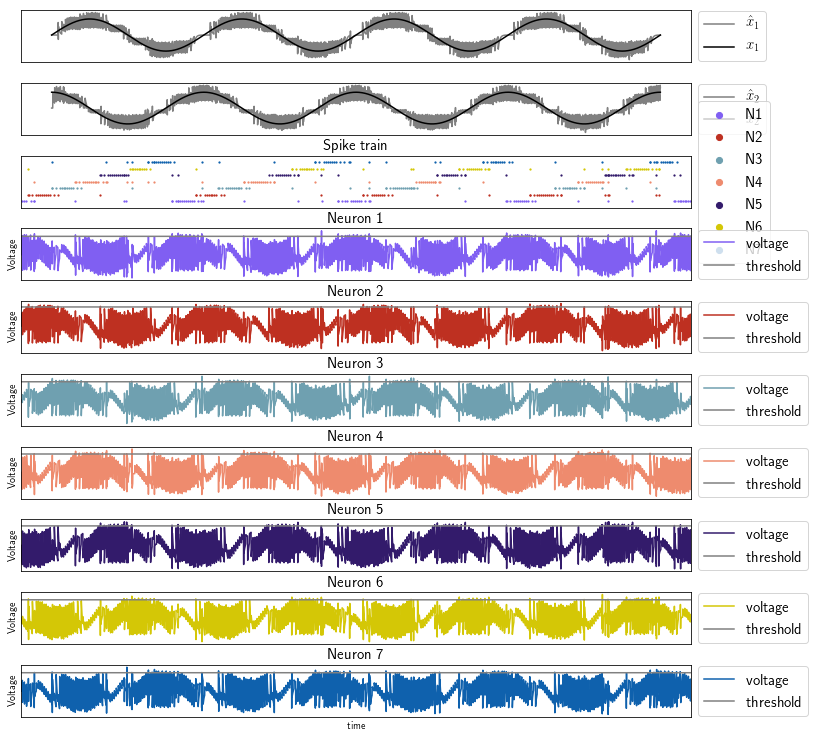

In [132]:
# Run simulation and plot results for given parameters
N = 7                                                    # number of neurons
d = 2                                                    # number of dimensions of signal input
iterations = 4000                                        # number of time steps
dt = 0.1                                                 # step size
tau = 1                                                  # time constant
beta = 0                                                 # cost constant
color = list(np.random.choice(range(256), size=(N, 3)))  # color map for plotting the different neurons

# run simulation
D = initialize_weights(N, d)                                                # initialize decoding weights
# print(D)
t, voltage, x_est, o, T = initialize_params_N(N, d, iterations, dt, D)      # initialize parameters
c, x = TVS_N(iterations)                                                    # create d-dimensional input signal
run_N(tau, beta)                                                            # run spiking network
plot_N(color)                                                               # plot results

Plot the weights of the neurons for a 2- or 3-dimensional input

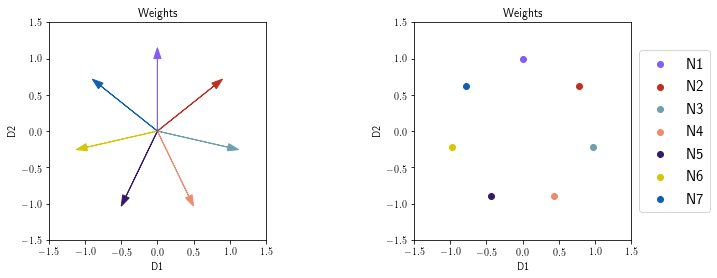

In [133]:
def plot_weights():
    """ Plot the weights for N neurons (2D and 3D input signal). """
        
    if d == 2:
    # 2-dimensional input signal
        
        plots = 2
        pl.subplots(plots, 1, figsize=(12, 4))
   
        # plot weights as arrows
        pl.subplot(1, 2, 1)
        pl.axis('square')
        for i in range(1, N + 1):
            arrow = pl.arrow(0, 0, D[i - 1, 0], D[i - 1, 1], color=color[i - 1][:]/255, head_width=0.1)
        pl.xlabel('D1')
        pl.ylabel('D2')
        pl.title('Weights')
        pl.xlim(-1.5, 1.5)
        pl.ylim(-1.5, 1.5)

        # plot weights as points
        pl.subplot(1, 2, 2)
        pl.axis('square')
        for i in range(1, N + 1):
            pl.scatter(D[i - 1][0], D[i - 1][1], color=color[i - 1][:]/255, label='N%i' %i)
        pl.xlabel('D1')
        pl.ylabel('D2')
        pl.xlim(-1.5, 1.5)
        pl.ylim(-1.5, 1.5)
        pl.title('Weights')
        pl.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15, markerscale=1)
        
    elif d == 3:
    # 3-dimensional input signal
        
        fig = pl.figure(figsize=(12,8))
        ax = pl.axes(projection='3d')
        
        # plot weights as points
        for i in range(1, N + 1):
            ax.scatter3D(D[i - 1][0], D[i - 1][1], D[i - 1][2], s=50, label='N%i' %i)
        ax.set_xlabel('D1')
        ax.set_ylabel('D2')
        ax.set_zlabel('D3')
        pl.title('Weights',fontsize=20)
        pl.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15, markerscale=1)
        
    else:
        print("No plot generated: function for 2D and 3D signal input only. ")
        
plot_weights()

## Bounding box

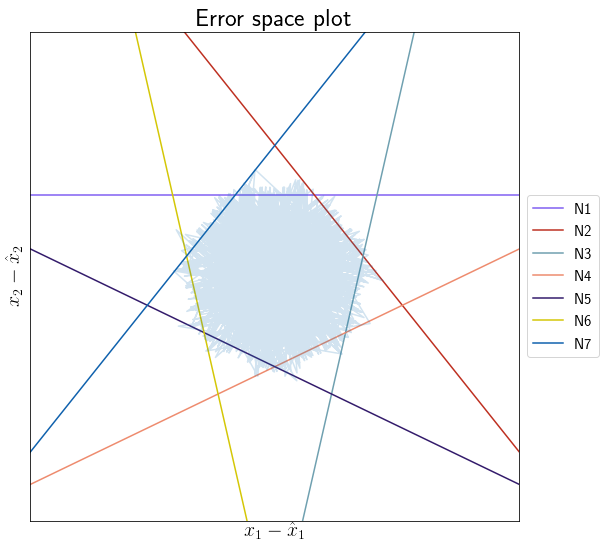

In [134]:
def plot_bounding_box(arrow=0):
    """ Plots error space with the bounding box with (arrow=1) or without (arrow=0) the weights of neurons. """
    
    if d == 2:
    # 2-dimensional input signal
    
        # enable LaTeX
        pl.rc('text', usetex=True)

        # plot bouding box
        fig = pl.figure(figsize=(16,9))
        pl.axis('square')
        
        steps = 2
        x1 = np.linspace(-10, 10, steps)
        for i in range(1, N + 1):
            x2 = np.zeros(steps)
            for j in range(steps):
                x2[j] = (T[i - 1] - x1[j] * D[i - 1, 0]) / D[i - 1, 1]
            pl.plot(x1, x2, label="N%i" %i, color=color[i - 1]/255)
        pl.yticks([])
        pl.xticks([])
        pl.xlim(-1.5, 1.5)
        pl.ylim(-1.5, 1.5)
        pl.xlabel('$x_{1} - \hat{x}_{1}$', fontsize=20)
        pl.ylabel('$x_{2} - \hat{x}_{2}$', fontsize=20)
        pl.title('Error space plot', fontsize=25)
        pl.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15, markerscale=1)

        # plot signal representtation error over time
        start = 100
        error = x[:, start:iterations] - x_est[:, start:iterations]
        pl.plot(error[0], error[1], alpha = 0.2)
        
        # plot arrow plot weights (if arrow = 1)
        if arrow == 1:
            for i in range(1, N + 1):
                arrow = pl.arrow(0, 0, D[i - 1, 0], D[i - 1, 1], color=color[i - 1][:]/255, head_width=0.1)
        
    else:
        print("No plot generated: function for 2D signal input only. ")
    
plot_bounding_box(0)

# Animation

C:\Users\amber\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
MovieWriter imagemagick unavailable.


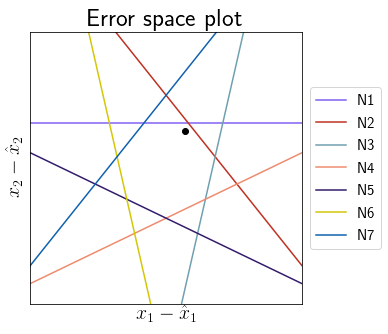

In [135]:
def bounding_box_animation(filename='BB.gif', arrow=0, interval=500):

    # initiate plot
    fig = pl.figure(figsize = (5,5))
    pl.axis('square')
    axes = fig.add_subplot(111)

    # compute representation error over time
    start = 100
    error = x[:, start:iterations] - x_est[:, start:iterations]
    error_x1 = error[0]
    error_x2 = error[1]
    point, = axes.plot([error_x1[0]],[error_x2[0]], 'ko')
    
    # returns coördinates error over time
    def ani(coords):
        point.set_data([coords[0]],[coords[1]])
        point.axes.axis([-1.5, 1.5, -1.5, 1.5])
        return point

    # return position error over time
    def frames():
        for error_x1_pos, error_x2_pos in zip(error_x1, error_x2):
            yield error_x1_pos, error_x2_pos
            
    # plot boundary box
    x1 = np.linspace(-10, 10, 2)
    x2 = np.zeros(2)
    for i in range(1, N + 1):
        for j in range(2):
            x2[j] = (T[i - 1] - x1[j] * D[i - 1, 0]) / D[i - 1, 1]
        pl.plot(x1, x2, label="N%i" %i, color=color[i - 1]/255)
    pl.yticks([])
    pl.xticks([])
    pl.xlim(-1.5, 1.5)
    pl.ylim(-1.5, 1.5)
    pl.xlabel('$x_{1} - \hat{x}_{1}$', fontsize=20)
    pl.ylabel('$x_{2} - \hat{x}_{2}$', fontsize=20)
    pl.title('Error space plot', fontsize=25)
    pl.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15, markerscale=1)

    # plot weights as arrows
    if arrow == 1:
        for i in range(1, N + 1):
                arrow = pl.arrow(0, 0, D[i - 1, 0], D[i - 1, 1], color=color[i - 1][:]/255, head_width=0.1)
            
    # runs animation
    ani = animation.FuncAnimation(fig, ani, frames=frames, interval=interval)
    ani.save(filename + '.gif', writer='imagemagick') # save as .gif
    pl.show()
    
bounding_box_animation('D2_N10')